Epoch [1/500], Loss: 151.6472, R²: -0.8971, Validation R²: 0.9312
最优模型已保存到: E:\daore1\best_model_r2.pth
Epoch [2/500], Loss: 12.7537, R²: 0.8614, Validation R²: 0.9133
Epoch [3/500], Loss: 9.1295, R²: 0.8866, Validation R²: 0.9442
最优模型已保存到: E:\daore1\best_model_r2.pth
Epoch [4/500], Loss: 8.8384, R²: 0.8902, Validation R²: 0.9163
Epoch [5/500], Loss: 6.9767, R²: 0.9138, Validation R²: 0.9497
最优模型已保存到: E:\daore1\best_model_r2.pth
Epoch [6/500], Loss: 7.1285, R²: 0.9120, Validation R²: 0.9551
最优模型已保存到: E:\daore1\best_model_r2.pth
Epoch [7/500], Loss: 7.7771, R²: 0.9056, Validation R²: 0.9552
最优模型已保存到: E:\daore1\best_model_r2.pth
Epoch [8/500], Loss: 5.7871, R²: 0.9292, Validation R²: 0.9199
Epoch [9/500], Loss: 7.0217, R²: 0.9133, Validation R²: 0.9175
Epoch [10/500], Loss: 6.0473, R²: 0.9246, Validation R²: 0.9583
最优模型已保存到: E:\daore1\best_model_r2.pth
Epoch [11/500], Loss: 4.9408, R²: 0.9385, Validation R²: 0.9559
Epoch [12/500], Loss: 5.6692, R²: 0.9308, Validation R²: 0.9581
Epoch [13

Epoch [119/500], Loss: 0.8118, R²: 0.9899, Validation R²: 0.9605
Epoch [120/500], Loss: 0.9999, R²: 0.9876, Validation R²: 0.9704
Epoch [121/500], Loss: 0.9337, R²: 0.9884, Validation R²: 0.9624
Epoch [122/500], Loss: 0.9306, R²: 0.9884, Validation R²: 0.9707
Epoch [123/500], Loss: 0.9773, R²: 0.9879, Validation R²: 0.9261
Epoch [124/500], Loss: 3.3453, R²: 0.9589, Validation R²: 0.9690
Epoch [125/500], Loss: 1.4278, R²: 0.9823, Validation R²: 0.9651
Epoch [126/500], Loss: 1.1681, R²: 0.9855, Validation R²: 0.9402
Epoch [127/500], Loss: 3.0601, R²: 0.9632, Validation R²: 0.9617
Epoch [128/500], Loss: 2.5178, R²: 0.9687, Validation R²: 0.9523
Epoch [129/500], Loss: 1.0898, R²: 0.9866, Validation R²: 0.9681
Epoch [130/500], Loss: 1.1946, R²: 0.9853, Validation R²: 0.9693
Epoch [131/500], Loss: 0.7315, R²: 0.9910, Validation R²: 0.9683
Epoch [132/500], Loss: 0.8663, R²: 0.9895, Validation R²: 0.9694
Epoch [133/500], Loss: 0.8213, R²: 0.9899, Validation R²: 0.9710
Epoch [134/500], Loss: 0.

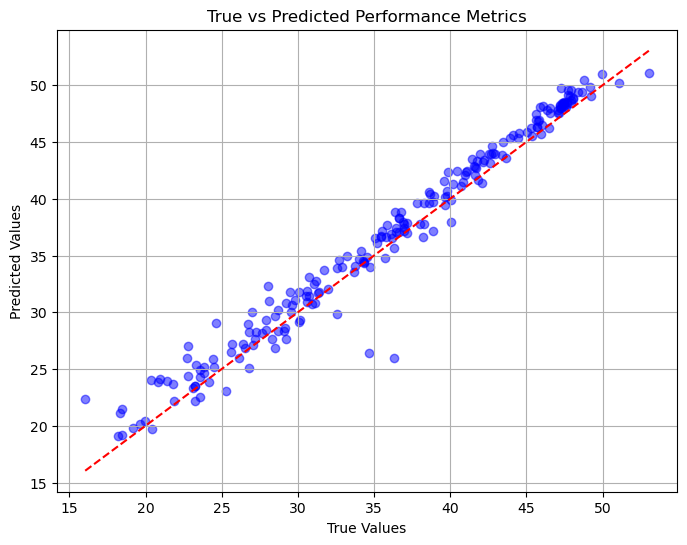

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 定义自定义数据集
class ImageDataset(Dataset):
    def __init__(self, image_folder, excel_file, transform=None):
        self.image_folder = image_folder
        self.df = pd.read_excel(excel_file)
        self.image_names = self.df.iloc[:, 0].astype(str).values  # 图片名称
        self.performance_metrics = self.df.iloc[:, 1].values      # 性能指标
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder, f"{img_name}")
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        target = torch.tensor(self.performance_metrics[idx], dtype=torch.float32)
        return img, target


# 定义 CNN 模型
class CNNRegressor(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNRegressor, self).__init__()
        
        # 定义卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # 定义池化层
        self.pool = nn.MaxPool2d(2, 2)
        
        # 定义 Dropout 层（加入正则化）
        self.dropout = nn.Dropout(p=dropout_rate)
        
        # 全连接层
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # 假设输入图片尺寸为128x128
        self.fc2 = nn.Linear(512, 1)  # 输出一个连续值
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        # Dropout 层
        x = self.dropout(x)
        
        # 展平
        x = x.view(x.size(0), -1)
        
        # 全连接层
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# 数据预处理
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 调整图片大小
    transforms.ToTensor(),          # 转换为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 数据集和数据加载器
image_folder = r'E:\daore1'
excel_file = r'E:\daore1\shuju.xlsx'  # 替换为你的文件名

dataset = ImageDataset(image_folder=image_folder, excel_file=excel_file, transform=transform)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 初始化模型、损失函数和优化器
model = CNNRegressor(dropout_rate=0.5).cuda()  # 使用 50% 的 Dropout
criterion = nn.MSELoss()       # 使用均方误差损失（用于训练）

# 添加 L2 正则化（weight_decay）
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 训练模型
num_epochs = 500
patience = 40  # 若验证 R² 在 5 个 epoch 内没有改善，则停止训练
best_r2 = -float('inf')  # 初始化最优 R² 为负无穷
patience_counter = 0

# 保存路径
best_model_path = r'E:\daore1\best_model_r2.pth'
last_model_path = r'E:\daore1\last_model.pth'

for epoch in range(num_epochs):
    model.train()  # 设定为训练模式
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        
        optimizer.zero_grad()  # 清空梯度
        outputs = model(inputs)  # 前向传播
        
        loss = criterion(outputs.squeeze(), targets)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        
        running_loss += loss.item()
        
        # 收集预测值和真实值，用于计算 R²
        all_preds.extend(outputs.cpu().detach().numpy())
        all_targets.extend(targets.cpu().detach().numpy())
    
    # 计算 R² 得分
    r2 = r2_score(all_targets, all_preds)
    
    # 在验证集上评估
    model.eval()  # 设定为评估模式
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
    
    val_r2 = r2_score(val_targets, val_preds)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, R²: {r2:.4f}, Validation R²: {val_r2:.4f}')
    
    # 早停法
    if val_r2 > best_r2:
        best_r2 = val_r2
        # 保存最优模型
        torch.save(model.state_dict(), best_model_path)
        print(f"最优模型已保存到: {best_model_path}")
        patience_counter = 0  # 重置 patience 计数器
    else:
        patience_counter += 1
    
    # 如果 patience_counter 达到 patience，则停止训练
    if patience_counter >= patience:
        print(f"验证 R² 没有改善，早停训练，最优模型保存在: {best_model_path}")
        break
    
    # 保存每个 epoch 的最后模型
    torch.save(model.state_dict(), last_model_path)

# 在测试集上评估并绘制评估图
model.eval()  # 设定为评估模式
test_preds = []
test_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        
        test_preds.extend(outputs.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

# 绘制评估图：真实值 vs 预测值
plt.figure(figsize=(8, 6))
plt.scatter(test_targets, test_preds, color='blue', alpha=0.5)
plt.plot([min(test_targets), max(test_targets)], [min(test_targets), max(test_targets)], color='red', linestyle='--')  # 参考线
plt.title('True vs Predicted Performance Metrics')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

